In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('final_features.csv')
df.head(2)

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,...,23.793560,-20.588538,-25.390728,12.380474,-19.671300,16.618838,30.438979,43.384339,5.521896,2.243536
1,1,0,0.666644,0.249997,0.666644,0.499988,0.499994,0.307690,0.0,1.0,...,68.032528,1.352752,-25.395078,-7.580498,-23.430201,3.710806,1.435839,44.218947,11.410592,22.943373


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Columns: 220 entries, id to 95_y
dtypes: float64(206), int64(14)
memory usage: 678.6 MB


In [4]:
#train_df = pd.read_csv('train.csv.zip')
y_true = df['is_duplicate'].values

# Train Test Split

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df, y_true, stratify = y_true, test_size = 0.2)

In [6]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Random Baseline Model

In [7]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss, classification_report

In [8]:
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((len(y_test),2))
for i in range(len(y_test)):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Validation Data using Random Model",round(log_loss(y_test, predicted_y,eps=1e-15),2))
#print(list(predicted_y))
predicted_y =np.argmax(predicted_y, axis=1)

Log loss on Validation Data using Random Model 0.88


In [9]:
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       0.63      0.50      0.56     51005
           1       0.37      0.50      0.43     29853

    accuracy                           0.50     80858
   macro avg       0.50      0.50      0.49     80858
weighted avg       0.54      0.50      0.51     80858



# Logistic Regression

Alpha values :  [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]
For values of alpha =  1e-05 The log loss is: 0.6585300338196387
For values of alpha =  0.0001 The log loss is: 0.6585300338196387
For values of alpha =  0.001 The log loss is: 0.6585300338196387
For values of alpha =  0.01 The log loss is: 0.6585300338196387
For values of alpha =  0.1 The log loss is: 0.6021442666835927
For values of alpha =  1 The log loss is: 0.568592310444322
For values of alpha =  10 The log loss is: 0.5505660788887634


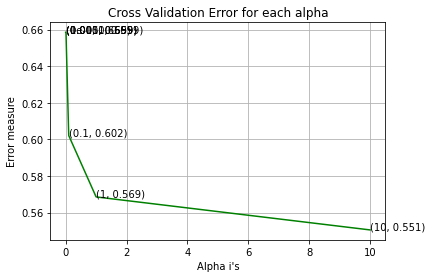

For values of best alpha =  10 The train log loss is: 0.551680773471412
For values of best alpha =  10 The test log loss is: 0.5505660788887634
Total number of data points : 80858


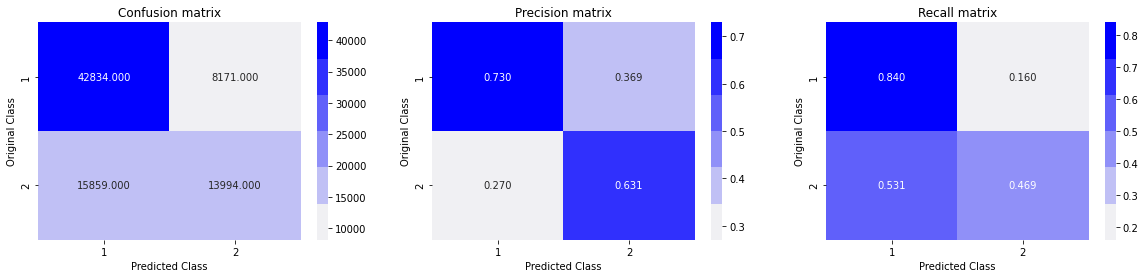

In [15]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.datasets import make_classification

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

print("Alpha values : ", alpha)

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Linear SVM

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.



CalibratedClassifierCV
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# XGBoost

In [10]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.datasets import make_classification

alpha = [10 ** x for x in range(-5, 2)]
clf = SGDClassifier(penalty='l1', loss='hinge', random_state=42)
clf.fit(x_train, y_train)

SGDClassifier(penalty='l1', random_state=42)

In [11]:
import xgboost as xgb
params = {}
params["objective"] = "binary:logistic"  #
params["eval_metric"] = "logloss" #
params["eta"] = 0.05   #
params["gamma"] = 0.1
#params["scale_pos_weight"] = 0.3632
params["tree_method"] = "gpu_hist"
#params["max_depth"] = 6   #
#params["min_child_weight"] = 4
#params["max_bin"] = 256
#params["subsample"] = 0.8
#params["colsample_bytree"] = 0.9

In [12]:
d_train = xgb.DMatrix(x_train, label=y_train)
d_test = xgb.DMatrix(x_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

In [16]:
bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(x_train,y_train)

[0]	train-logloss:0.64440	valid-logloss:0.64440
[10]	train-logloss:0.33669	valid-logloss:0.33669
[20]	train-logloss:0.18964	valid-logloss:0.18964
[30]	train-logloss:0.11045	valid-logloss:0.11045
[40]	train-logloss:0.06545	valid-logloss:0.06545
[50]	train-logloss:0.03916	valid-logloss:0.03916
[60]	train-logloss:0.02356	valid-logloss:0.02356
[70]	train-logloss:0.01422	valid-logloss:0.01422
[80]	train-logloss:0.00860	valid-logloss:0.00860
[90]	train-logloss:0.00521	valid-logloss:0.00521
[100]	train-logloss:0.00316	valid-logloss:0.00316
[110]	train-logloss:0.00192	valid-logloss:0.00192
[120]	train-logloss:0.00117	valid-logloss:0.00117
[130]	train-logloss:0.00071	valid-logloss:0.00071
[140]	train-logloss:0.00043	valid-logloss:0.00043
[150]	train-logloss:0.00026	valid-logloss:0.00026
[160]	train-logloss:0.00016	valid-logloss:0.00016
[170]	train-logloss:0.00010	valid-logloss:0.00010
[180]	train-logloss:0.00006	valid-logloss:0.00006
[190]	train-logloss:0.00004	valid-logloss:0.00004
[200]	train

In [17]:
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

The test log loss is: 6.6903418617636e-06


Total number of data points : 80858


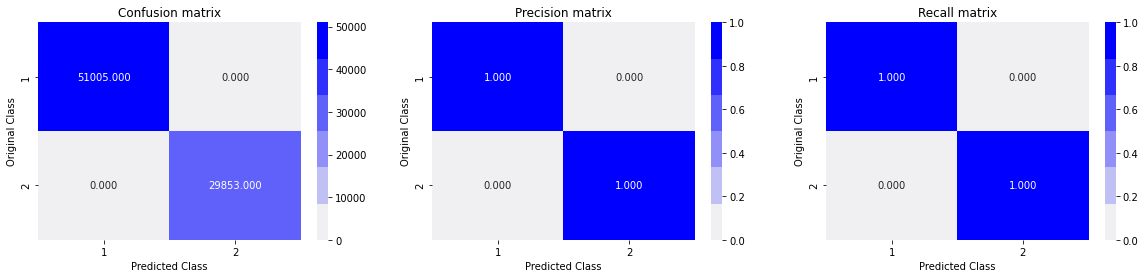

In [18]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)